In [2]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
DATA_DIR = u"data/sjukfrånvaro"
file_name = u"HypergeneExport_View_1_20170307_31253359.xls"
population_file = u"HypergeneExport_View_1_20170307_50374656.xls"
rename = {u"Visat Värde": "value", "Nyckeltal": "KPI", "Kommun/Landsting": "region", u"Kön": "gender", u"År": "year",}

file_path = os.path.join(DATA_DIR, file_name)
df = pd.read_excel(file_path)
df = df.rename(columns=rename)
df = df.set_index(["KPI","gender","region" ])

df_pop = pd.read_excel(os.path.join(DATA_DIR, population_file))\
    .rename(columns=rename)[["region", "value"]]\
    .set_index("region")
df_pop["population"] = pd.to_numeric(df_pop.value)

df_muni_group = pd.read_csv(os.path.join(DATA_DIR, "kommungrupper.csv"), encoding="utf-8")\
    .rename(columns={"Kommun namn": "region"})\
    .set_index("region")[u'Kommungrupp 2017 namn']
    


In [4]:
def to_regional_df(df, KPI, gender):
    _df = df.loc[(KPI, gender)].pivot(columns="year")
    
    # last year vs mean
    _df["_mean"] = _df.value.mean(axis=1)
    _df["latest_vs_mean"] = _df.value.iloc[:,-1] / _df._mean
    _df["latest_value"] = _df.value.iloc[:,-1]
    _df["diff_vs_prev_year"] = _df.value.iloc[:,-1] - _df.value.iloc[:,-2]
    _df["diff_vs_prev_year_2015"] = _df.value.loc[:,2015] - _df.value.loc[:,2014]
    _df["diff_vs_2011"] = _df.value.iloc[:,-1] - _df.value.loc[:,2011]
    _df["population"] = _df.join(df_pop.population).population
    return _df

df_k = to_regional_df(df, u"Sjukfrånvaro kommunalt anställda totalt, (%)", u"Totalt")
df_k_men = to_regional_df(df, u"Sjukfrånvaro kommunalt anställda totalt, (%)", u"Män")
df_k_women = to_regional_df(df, u"Sjukfrånvaro kommunalt anställda totalt, (%)", u"Kvinnor")

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  from IPython.kernel.zmq import kernelapp as app
/Library/Python/2.7/site-packages/pandas/tools/merge.py:489: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [5]:
def plot_muni_vs_country(region):
    fig, ax = plt.subplots()
    df_k.loc[region].value.plot(ax=ax)
    df_k.loc["Riket"].value.T.plot(ax=ax)
    labels = [region, "Riket"] 
    lines, _ = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')
    ax.set_ylim(0)
    plt.show()

## Hur ser utvecklingen i riket ut?

(0, 7.3050000000000006)

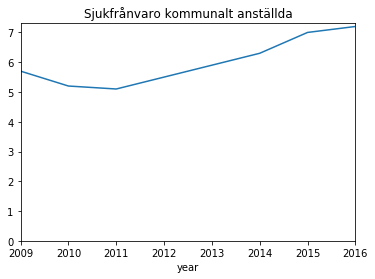

In [6]:
ax = df_k.loc["Riket"].value.plot(title=u"Sjukfrånvaro kommunalt anställda")
ax.set_ylim(0)

## Hur ser utvecklingen för män och kvinnor ut?

(0, 8.125)

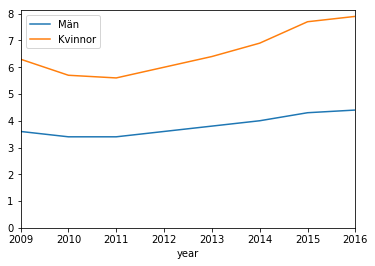

In [7]:
fig, ax = plt.subplots()

df_k_men.loc["Riket"].value.plot()
df_k_women.loc["Riket"].value.plot()


labels = [u"Män", u"Kvinnor"] 
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

ax.set_ylim(0)

In [8]:
men_increase = df_k_men.loc["Riket"].value.iloc[-1] / df_men.loc["Riket"].value.loc[2011] 
women_increase = df_k_women.loc["Riket"].value.iloc[-1] / df_women.loc["Riket"].value.loc[2011] 

print u"Ökning för kvinnor sedan 2011: {}".format(women_increase)
print u"Ökning för män sedan 2011: {}".format(men_increase)

NameError: name 'df_men' is not defined

In [9]:
# To Excel
df_gender = pd.concat([df_k_men.loc["Riket"].value, df_k_women.loc["Riket"].value], axis=1)
df_gender.columns = [u"Män", "Kvinnor"]
df_gender.to_excel("gender_diff.xlsx")
df_gender

,Män,Kvinnor
year,,
2009,3.6,6.3
2010,3.4,5.7
2011,3.4,5.6
2012,3.6,6.0
2013,3.8,6.4
2014,4.0,6.9
2015,4.3,7.7
2016,4.4,7.9


## Hur ser utvecklingen i olika åldersgrupper ut?

In [10]:
df.index.get_level_values(0).unique()

Index([u'Sjukfrånvaro för kommunalt anställda <30 år, (%)',
       u'Sjukfrånvaro för kommunalt anställda >49 år, (%)',
       u'Sjukfrånvaro för kommunalt anställda 30-49 år, (%)',
       u'Sjukfrånvaro för landstingsanställda < 30 år, andel (%)',
       u'Sjukfrånvaro för landstingsanställda > 49 år, andel (%)',
       u'Sjukfrånvaro för landstingsanställda 30-49 år, andel (%)',
       u'Sjukfrånvaro kommunalt anställda mer än 59 dagar som andel av total sjukfrånvaro, (%)',
       u'Sjukfrånvaro kommunalt anställda totalt, (%)',
       u'Sjukfrånvaro landstingsanställda mer än 59 dagar som andel av total sjukfrånvaro, (%)',
       u'Sjukfrånvaro landstingsanställda totalt, andel (%)'],
      dtype='object', name=u'KPI')

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  from IPython.kernel.zmq import kernelapp as app


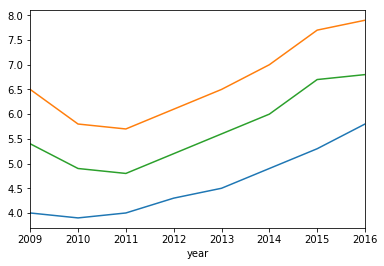

In [11]:
age_groups = [
    u'Sjukfrånvaro för kommunalt anställda <30 år, (%)',
    u'Sjukfrånvaro för kommunalt anställda >49 år, (%)',
    u'Sjukfrånvaro för kommunalt anställda 30-49 år, (%)',
]
fig, ax = plt.subplots()
for age_group in age_groups:
    _df = to_regional_df(df, age_group, "Totalt")
    _df.loc["Riket"].value.T.plot(ax=ax)


## Hur ser utvecklingen i landstingen ut?

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  from IPython.kernel.zmq import kernelapp as app


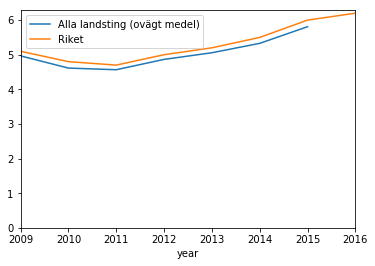

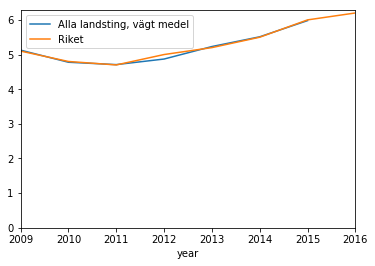

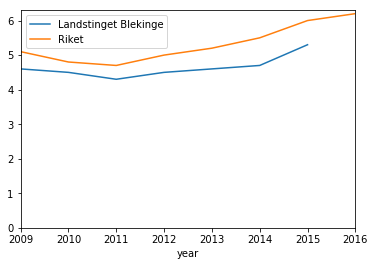

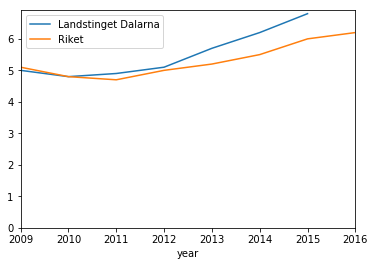

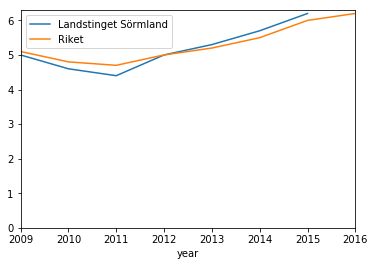

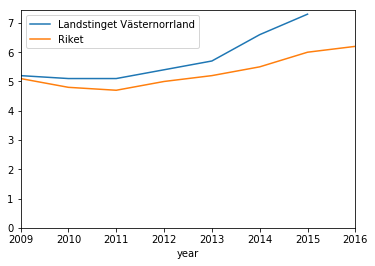

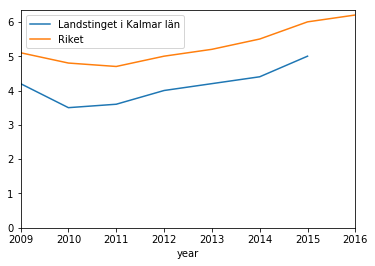

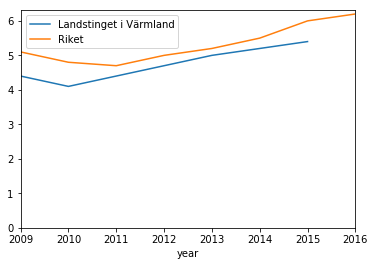

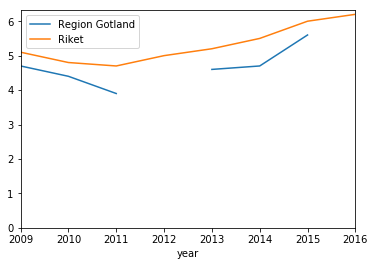

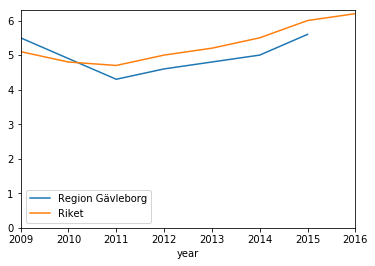

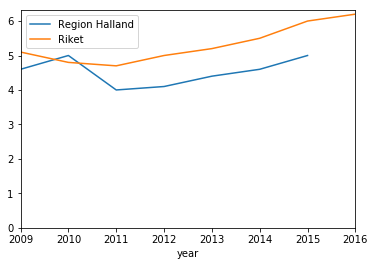

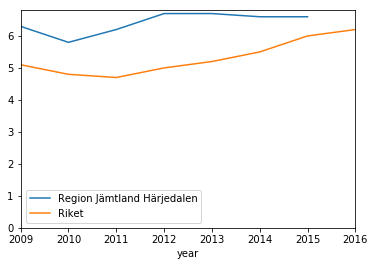

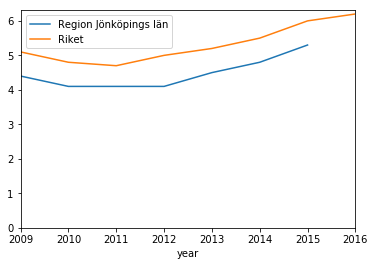

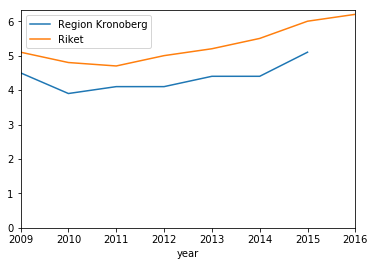

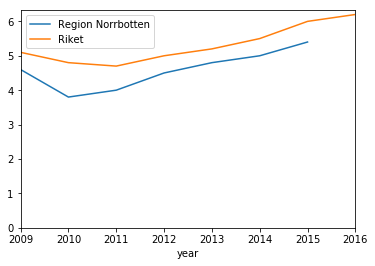

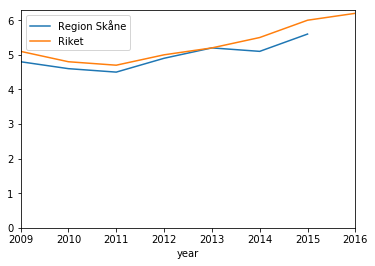

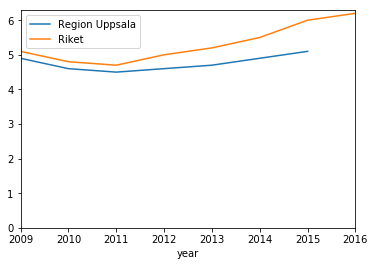

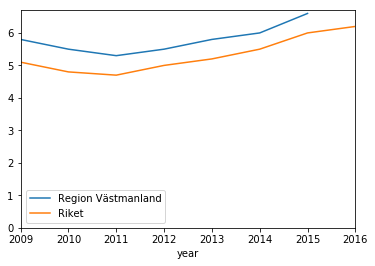

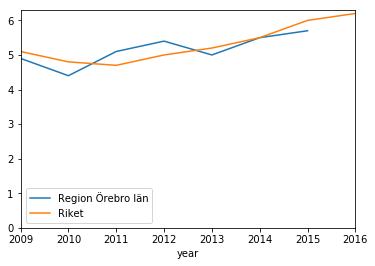

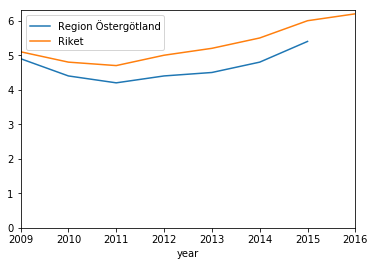

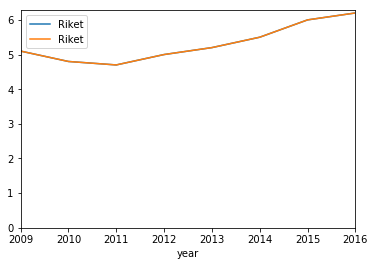

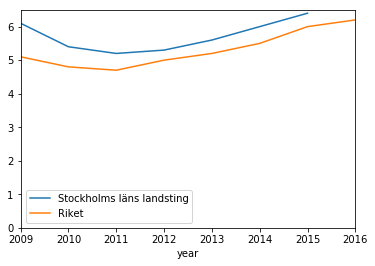

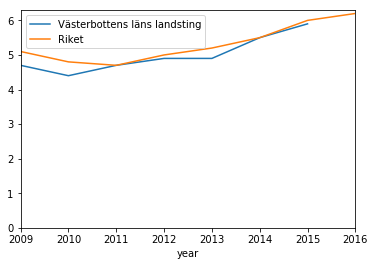

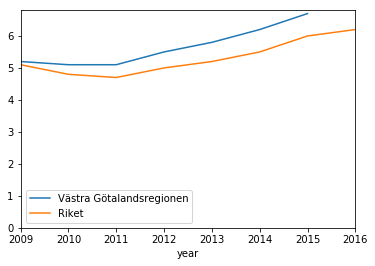

In [12]:


df_lt = to_regional_df(df, u"Sjukfrånvaro landstingsanställda totalt, andel (%)", "Totalt")

for region, _df in df_lt.groupby(level=0):
    fig, ax = plt.subplots()
    _df.value.T.plot(ax=ax)
    df_lt.loc["Riket"].value.T.plot(ax=ax)
    labels = [region, "Riket"] 
    lines, _ = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')
    ax.set_ylim(0)
    plt.show()


## Vilka kommuner har ökat/minskat mest senaste året?

Förändring jämfört med året innan.

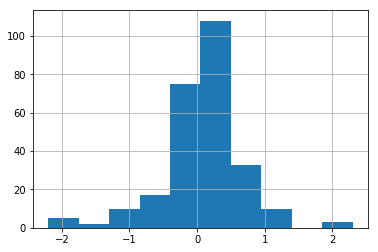

In [13]:
is_muni = ~df_k.index.str.contains("medel")
df_k[is_muni].diff_vs_prev_year.hist() 

In [14]:
has_increase_2016 = df_k.diff_vs_prev_year > 0
has_decrease_2016 = df_k.diff_vs_prev_year < 0
n_inrease = len(df_k[has_increase_2016 & is_muni])
n_decrease = len(df_k[has_decrease_2016 & is_muni])

print u"Utvecklingen i år:"
print u"Ökar : {}".format(n_inrease)
print u"Minskar: {}".format(n_decrease)

Utvecklingen i år:
Ökar : 154
Minskar: 87


In [15]:
has_increase_2015 = df_k.diff_vs_prev_year_2015 > 0
has_decrease_2015 = df_k.diff_vs_prev_year_2015 < 0

n_inrease = len(df_k[has_increase_2015 & is_muni])
n_decrease = len(df_k[has_decrease_2015 & is_muni])

print u"Utvecklingen i år:"
print u"Ökar : {}".format(n_inrease)
print u"Minskar: {}".format(n_decrease)

Utvecklingen i år:
Ökar : 242
Minskar: 21


In [16]:

has_turned = df_k[has_decrease_2016 & has_increase_2015 & is_muni]
has_turned.value


year,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,
Ale,5.5,5.1,NaN,5.1,6.3,6.9,7.8,6.8
Alingsås,5.4,5.2,5.0,NaN,6.3,6.5,7.5,7.3
Arjeplog,NaN,NaN,6.1,NaN,7.2,8.1,9.1,8.2
Askersund,5.6,5.4,5.2,5.7,5.8,6.3,7.0,6.9
Avesta,6.1,5.0,5.1,5.3,5.7,6.6,7.0,6.7
Bengtsfors,5.2,4.5,4.8,4.6,4.9,5.3,5.6,5.3
Bjuv,4.7,4.3,4.4,4.8,6.2,6.4,7.5,6.7
Borlänge,4.8,4.6,4.8,5.5,6.3,6.8,7.7,7.6
Eda,3.8,NaN,NaN,4.7,NaN,5.9,6.3,6.1


Störst ökning jämfört med året innan.


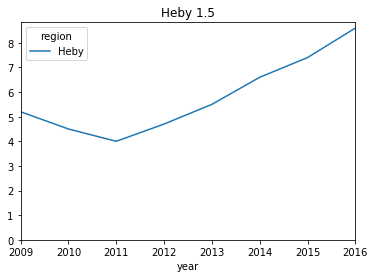

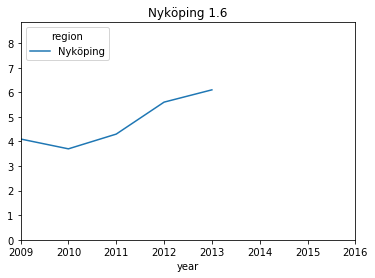

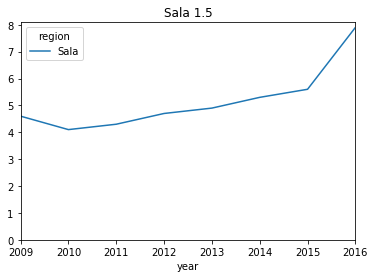

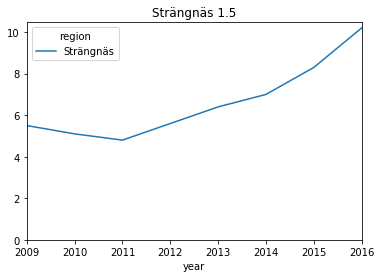

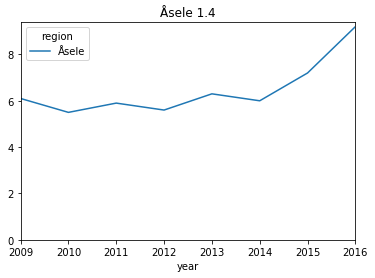

In [17]:
for region, _df in df_k.sort_values("latest_vs_mean", ascending=False).head().groupby(level=0):
    ax = _df.value.T.plot(title=u"{} {}".format(region, _df.latest_vs_mean.iloc[0].round(1)))
    ax.set_ylim(0)


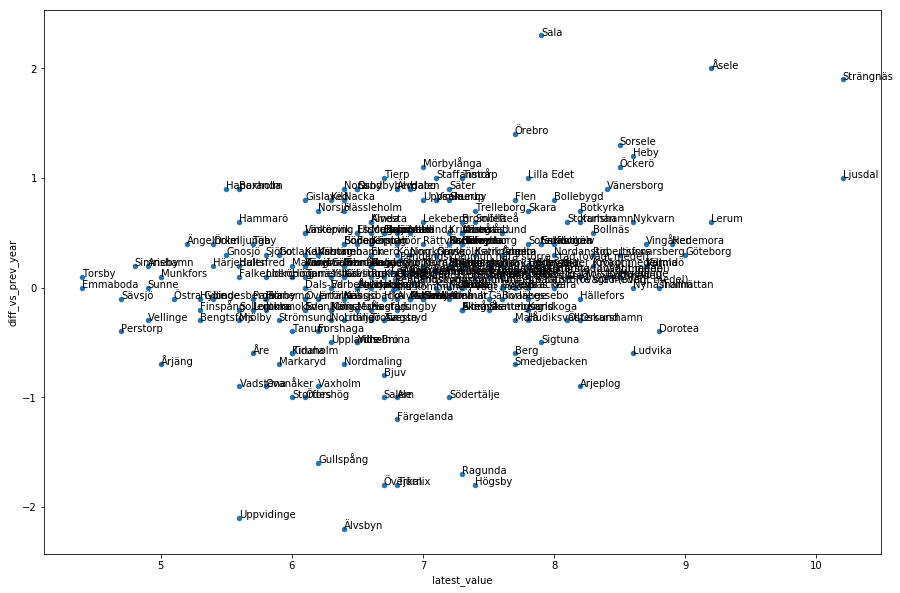

In [18]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    
    for i, point in a.iterrows():
        if not np.isnan(point['x']) and not np.isnan(point['y']):
            ax.text(point['x'], point['y'], unicode(point['val']))


y = "diff_vs_prev_year"
x = "latest_value"
ax = df_k.plot.scatter(x, y, figsize=(15,10))
_df = df_k.reset_index()
label_point(_df[x], _df[y], _df.region, ax)


## Samband mellan kommunstorlek och sjukfrånvaro?


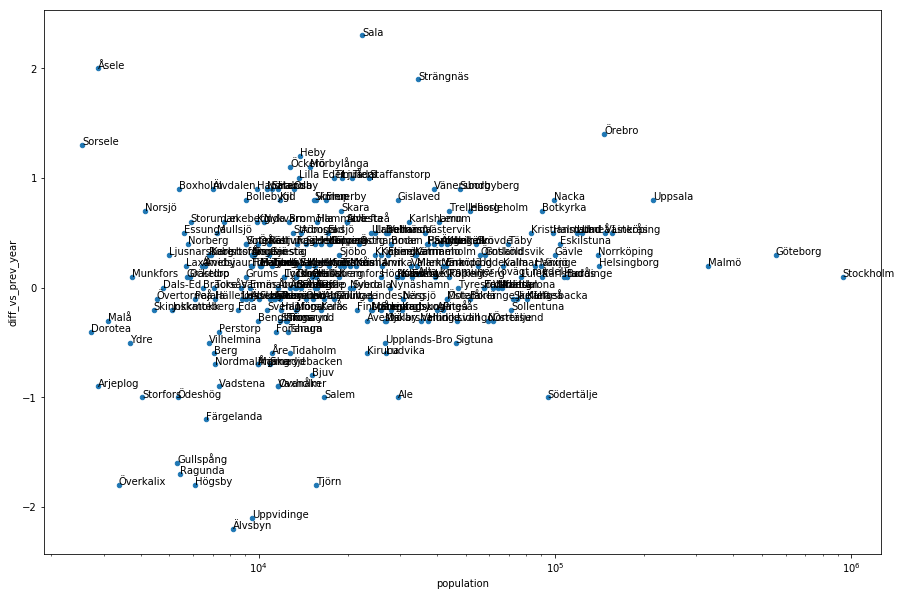

In [19]:
y = "diff_vs_prev_year"
x = "population"
ax = df_k.plot.scatter(x, y, figsize=(15,10))
ax.set_xscale('log')
_df = df_k.reset_index()
label_point(_df[x], _df[y], _df.region, ax)


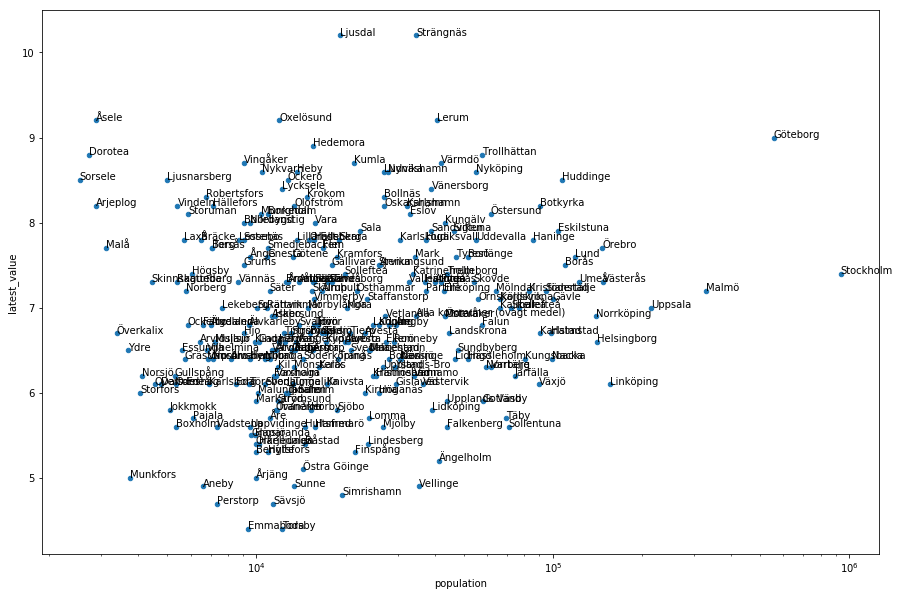

In [20]:
y = "latest_value"
x = "population"
ax = df_k.plot.scatter(x, y, figsize=(15,10))
ax.set_xscale('log')
_df = df_k.reset_index()
label_point(_df[x], _df[y], _df.region, ax)


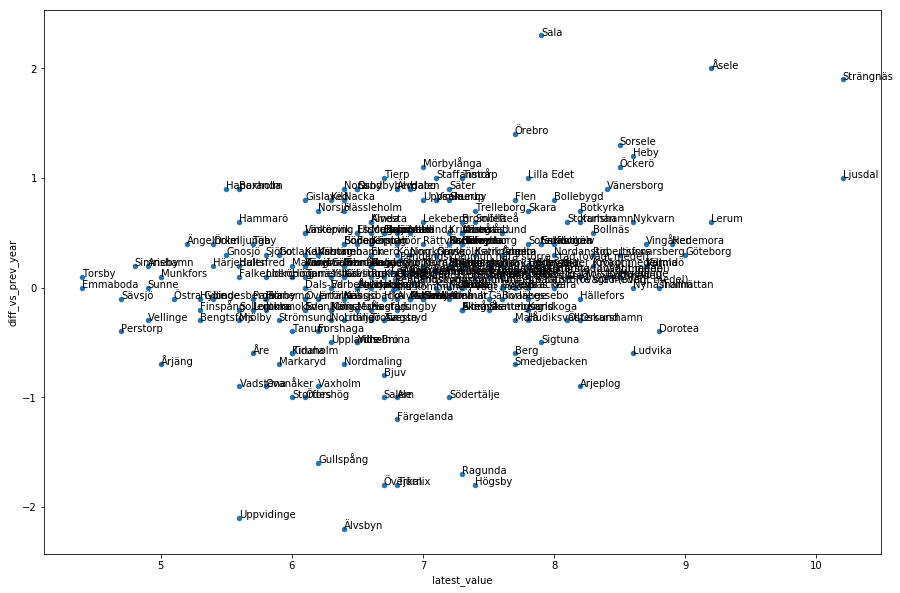

In [28]:
y = "diff_vs_prev_year"
x = "latest_value"
ax = df_k.plot.scatter(x, y, figsize=(15,10))
_df = df_k.reset_index()
label_point(_df[x], _df[y], _df.region, ax)


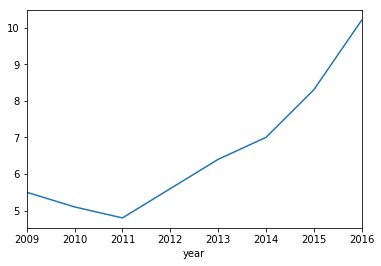

In [22]:
df_k.loc[u"Strängnäs"].value.plot()

Kommuner med negativ utveckling

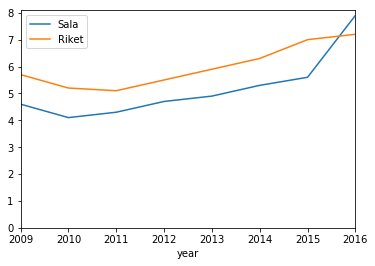

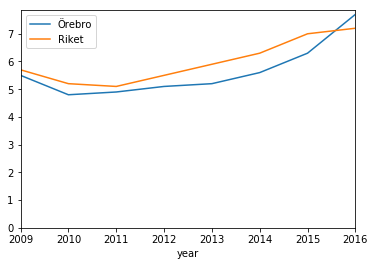

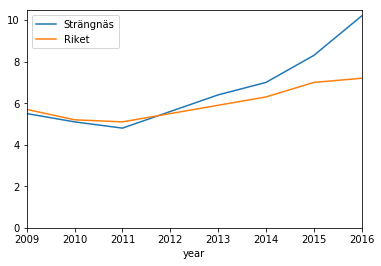

In [23]:
problem_munis = ["Sala", u"Örebro", u"Strängnäs"]
for region in problem_munis:    
    plot_muni_vs_country(region)

df_k.loc[problem_munis].value.to_excel("problem_munis.xlsx")

Kommuner med positiv utveckling

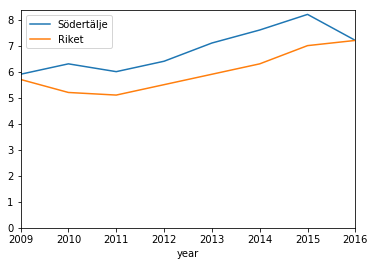

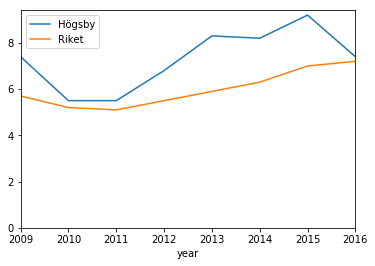

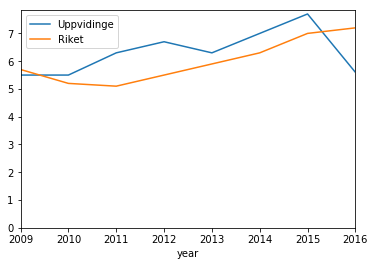

In [24]:
success_munis = [u"Södertälje",u"Högsby",u"Uppvidinge"]
for region in success_munis:    
    plot_muni_vs_country(region)

df_k.loc[success_munis].value.to_excel("success_munis.xlsx")

In [25]:
df_k.loc["Riket"].value.reset_index().to_excel(os.path.join(DATA_DIR, "riket.xlsx"))

In [26]:
df_all = df_k[["latest_value", "diff_vs_prev_year", "diff_vs_2011"]]
df_all.columns = ["2016", u"Förändring sedan 2015", u"Förändring sedan 2011"]
df_all.to_excel(os.path.join(DATA_DIR, "alla kommuner.xlsx"))

In [27]:
_df = df_k.value.loc[:,2015]
_df["_rank"] = _df.rank()
_df

/Library/Python/2.7/site-packages/pandas/core/series.py:747: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value
/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py:3032: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


region
Ale                                                                          7.8
Alingsås                                                                     7.5
Alla kommuner (ovägt medel)                                              6.78094
Alla kommuner, vägt medel                                                6.78599
Alvesta                                                                        6
Aneby                                                                        4.7
Arboga                                                                       6.8
Arjeplog                                                                     9.1
Arvidsjaur                                                                   6.4
Arvika                                                                       7.3
Askersund                                                                      7
Avesta                                                                         7
Bengtsfors           